# Import libraries

In [1]:
import sigma
from sigma.utils import normalisation as norm 
from sigma.utils import visualisation as visual
from sigma.utils.load import SEMDataset
from sigma.src.utils import same_seeds
from sigma.src.dim_reduction import Experiment
from sigma.models.autoencoder import AutoEncoder
from sigma.src.segmentation import PixelSegmenter
from sigma.gui import gui

# Load files

Load the *.bcf* file and create an object of `SEMDataset` (which uses hyperspy as backend.)

In [2]:
file_path = 'CAI19_ROI1.bcf'
sem = SEMDataset(file_path)

# Dataset preprocessing

## View the dataset

Use `gui.view_bcf_dataset(sem)` to check the BSE image, the sum spectrum, and the elemental maps. Here we can use the small widgets to search the energy peaks and determine the elements for further amalyses. 

After setting the `Feature list`, we obtain the elemental maps hyperspectral imaging dataset (HSI) with the dimension of 279 x 514 x 9 (for the test file).

In [3]:
gui.view_bcf_dataset(sem)

Output()

Output()

In addition to the GUI, we can view the dataset with the `sem` object:

1. `sem.bse`: access the back-scattered electron (as a hyperspy format).

2. `sem.edx`: access the edx dataset (as a hyperspy format).

3. `visual.plot_sum_spectrum(sem.edx)`: view the sum spectrum (or use hyperspy built-in function `sem.edx.sum().plot(xray_lines=True)`).

4. `sem.feature_list`: view the default chosen elemental peaks in the edx dataset.

5. `sem.set_feature_list`: set new elemental peaks. 

## Process the dataset

### Several (optional) functions to process the dataset:
1. `sem.rebin_signal(size=(2,2))`: rebin the edx signal with the size of 2x2. After rebinning the dataset, we can access the binned edx or bse data using `sem.edx_bin` or `sem.bse_bin`.

2. `sem.peak_intensity_normalisation()`: normalise the x-ray intensity along energy axis.

3. `sem.remove_fist_peak(end=0.1)`: remove the first x-ray peak (most likely noise) by calling the function with the argument `end`.

4. `sem.peak_denoising_PCA`: denoise the spectrum using *Principle Component Analysis (PCA)*.

    > `n_components_to_reconstruct`: specify how many components to reconstruct the the EDX intensity profile.  
    > `plot_results`: True to plot all results.

5. `visual.plot_intensity_maps`: Plot the elemental intensity maps.

In [3]:
# Rebin both edx and bse dataset
sem.rebin_signal(size=(2,2))

# normalisation to make the spectrum of each pixel summing to 1.
sem.peak_intensity_normalisation()

# Remove the first peak until the energy of 0.1 keV
sem.remove_fist_peak(end=0.1) 

# Denoise the X-ray profile using PCA.
sem.peak_denoising_PCA(n_components_to_reconstruct=10, plot_results=False)

Rebinning the intensity with the size of (2, 2)
Normalising the chemical intensity along axis=2, so that the sum is wqual to 1 along axis=2.
Removing the fisrt peak by setting the intensity to zero until the energy of 0.1 keV.
Peak denoising using PCA.
Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=10
  centre=None


<EDSSEMSpectrum, title: EDX, dimensions: (393, 303|1024)>

In [ ]:
# View the dataset (bse, edx etc.) again to check differences.
gui.view_bcf_dataset(sem)

The pre-processing steps yield a HSI datacube with the dimension of 139 x 257 x 9 (due to the 2x2 binning).

## Normalisation

Before dimensionality reduction, we normalise the elemental maps use `sem.normalisation()`, where we can pass a list containing (optional) sequential normalisation steps.

In [4]:
# Normalise the dataset using the (optional) sequential three methods.
sem.normalisation([norm.neighbour_averaging, 
                   norm.zscore, 
                   norm.softmax])

Set feature_list to ['Al_Ka', 'C_Ka', 'Ca_Ka', 'Fe_Ka', 'Mg_Ka', 'O_Ka', 'Si_Ka', 'Ti_Ka']
Normalise dataset using:
    1. neighbour_averaging
    2. zscore
    3. softmax


Use `gui.view_pixel_distributions` to view the intensity distributions after each sequential normalisation process.

In [ ]:
gui.view_pixel_distributions(sem, 
                             norm_list=[norm.neighbour_averaging,
                                        norm.zscore,
                                        norm.softmax], 
                             peak='Fe_Ka', 
                             cmap='inferno')

## (Optional) Assign RGB to elemental peaks

In [ ]:
gui.view_rgb(sem)

## Check elemental distribution after normalisation

In [ ]:
print('After normalisation:')
gui.view_intensity_maps(edx=sem.normalised_elemental_data, element_list=sem.feature_list)

# Dimensionality reduction: Autoencoder

## Initialise experiment / model

In [5]:
# The integer in this function can determine different initialised parameters of model (tuning sudo randomness)
# This can influence the result of dimensionality reduction and change the latent space.
same_seeds(1)

# Set up the experiment, e.g. determining the model structure, dataset for training etc.
general_results_dir='./' 
ex = Experiment(descriptor='softmax',
                general_results_dir=general_results_dir,
                model=AutoEncoder,
                model_args={'hidden_layer_sizes':(512,256,128)}, # number of hidden layers and corresponding neurons
                chosen_dataset=sem.normalised_elemental_data,
                save_model_every_epoch=True)

model_name: Model-softmax
size_dataset: (303, 393, 8)
device: cpu
num_parameters: 341770


## Training

In [6]:
# Train the model
ex.run_model(num_epochs=5,
             patience=50, 
             batch_size=64,
             learning_rate=1e-4, 
             weight_decay=0.0, 
             task='train_all', # Change to 'train_eval' to train on the training set (85% dataset) and test on a testing set (15%) for evaluation
             noise_added=0.0,
             KLD_lambda=0.0,
             criterion='MSE',
             lr_scheduler_args={'factor':0.5,
                                'patience':5, 
                                'threshold':1e-2, 
                                'min_lr':1e-6,
                                'verbose':True}) 

num_epochs: 5
batch_size: 64
task: train_all
optimizer: lr=0.0001 and weight_decay=0.0

Start training ...



  0%|          | 0/1861 [00:00<?, ?batch/s]

Epoch 1 ----> model saved, train_loss=0.001849 | test_loss = 0.001849


  0%|          | 0/1861 [00:00<?, ?batch/s]

Epoch 2 ----> model saved, train_loss=0.000994 | test_loss = 0.000994


  0%|          | 0/1861 [00:00<?, ?batch/s]

Epoch 3 ----> model saved, train_loss=0.000910 | test_loss = 0.000910


  0%|          | 0/1861 [00:00<?, ?batch/s]

Epoch 4 ----> model saved, train_loss=0.000857 | test_loss = 0.000857


  0%|          | 0/1861 [00:00<?, ?batch/s]

Epoch 5 ----> model saved, train_loss=0.000826 | test_loss = 0.000826


# Pixel segmentation: Gaussian mixture modelling (GMM) clustering

## (Optional) Load pre-trained Autoencoder

In [ ]:
model_path = '2022-04-18_Model-softmax/params/Model-softmax_epoch100' # model path
ex.load_trained_model(model_path)

## Measure Baysian information criterion (BIC)

The `gui.view_bic` iteratively calculates the BIC for Gaussian mixture models using the number of Gaussian components `n_components`, e.g. if `n_components=20`, it shows the BIC values for GMM using n_components from 1 to 20.

In [ ]:
latent = ex.get_latent()
gui.view_bic(latent,
             n_components=20,
             model_args={'random_state':6, 'init_params':'kmeans'})

## Run GMM

In [7]:
latent = ex.get_latent()
ps = PixelSegmenter(latent, 
                    sem.normalised_elemental_data, 
                    sem,
                    method_args={'n_components':12, 'random_state':6, 'init_params':'kmeans'} )
                    # can change random_state to different integer i.e. 10 or 0 to adjust the clustering result.

## Checking latent space

In [21]:
# Plot latent sapce (2-dimensional) with corresponding Gaussian models
gui.view_latent_space(ps, color=True)

In [ ]:
# visualise the latent space
gui.check_latent_space(ps,ratio_to_be_shown=0.5, show_map=True)

In [ ]:
# check the density of latent space
gui.plot_latent_density(ps, bins=50)

## Checking each clusters

In [8]:
# ps.set_feature_list(['Al_Ka', 'C_Ka', 'Ca_Ka', 'Fe_Ka', 'K_Ka', 'O_Ka', 'Si_Ka', 'Ti_Ka', 'Zn_La'])
ps.set_feature_list(['Al_Ka', 'C_Ka', 'Ca_Ka', 'Fe_Ka', 'Mg_Ka', 'O_Ka', 'Si_Ka', 'Ti_Ka'])
gui.show_cluster_distribution(ps)

Set feature_list to ['Al_Ka', 'C_Ka', 'Ca_Ka', 'Fe_Ka', 'Mg_Ka', 'O_Ka', 'Si_Ka', 'Ti_Ka']


SelectMultiple(options=('All', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', '…

Output()

Output()

## Checking cluster map

In [ ]:
# Plot phase map using the corresponding GM model
gui.view_phase_map(ps)

In [ ]:
gui.view_clusters_sum_spectra(ps, normalisation=True, spectra_range=(0,8))

# Unmixing cluster spectrums using Non-negative Matrix Fatorization (NMF)

In [9]:
weights, components = ps.get_unmixed_edx_profile(clusters_to_be_calculated='All', 
                                                 n_components='All',
                                                 normalised=False, 
                                                 method='NMF', 
                                                 method_args={'init':'nndsvd'})

In [10]:
gui.show_unmixed_weights_and_compoments(ps, weights, components)

# Check abundance map for components (using RGB maps)

In [11]:
gui.show_abundance_map(ps, weights, components)

Output()

# Statistics infro from clusters

In [ ]:
gui.show_cluster_stats(ps)

In [39]:
import numpy as np
import matplotlib.pyplot as plt

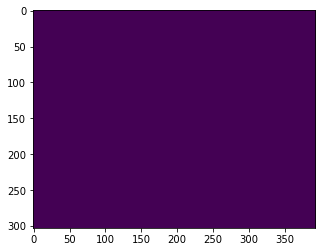

In [43]:
def get_binary_map_edx_profile(
        ps,
        cluster_num=1,
        use_label=False,
        threshold=0.8,
        denoise=False,
        keep_fraction=0.13,
        binary_filter_threshold=0.2,
    ):
        if use_label == False:
            if ps.method in ["GaussianMixture", "BayesianGaussianMixture"]:
                phase = ps.model.predict_proba(ps.latent)[:, cluster_num]

                if denoise == False:
                    binary_map = np.where(phase > threshold, 1, 0).reshape(
                        ps.height, ps.width
                    )
                    binary_map_indices = np.where(
                        phase.reshape(ps.height, ps.width) > threshold
                    )

            else:
                binary_map = (
                    ps.model.labels_
                    * np.where(ps.model.labels_ == cluster_num, 1, 0)
                ).reshape(ps.height, ps.width)
                binary_map_indices = np.where(
                    ps.model.labels_.reshape(ps.height, ps.width) == cluster_num
                )
        else:
            binary_map = (
                ps.labels * np.where(ps.labels == cluster_num, 1, 0)
            ).reshape(ps.height, ps.width)
            binary_map_indices = np.where(
                ps.labels.reshape(ps.height, ps.width) == cluster_num
            )
        
        # Get edx profile in the filtered phase region
        x_id = binary_map_indices[0].reshape(-1, 1)
        y_id = binary_map_indices[1].reshape(-1, 1)
        x_y = np.concatenate([x_id, y_id], axis=1)
        x_y_indices = tuple(map(tuple, x_y))

        total_edx_profiles = list()
        for x_y_index in x_y_indices:
            total_edx_profiles.append(ps.edx.data[x_y_index].reshape(1, -1))
        total_edx_profiles = np.concatenate(total_edx_profiles, axis=0)

        size = ps.edx.axes_manager[2].size
        scale = ps.edx.axes_manager[2].scale
        offset = ps.edx.axes_manager[2].offset
        energy_axis = [((a * scale) + offset) for a in range(0, size)]

        element_intensity_sum = total_edx_profiles.sum(axis=0)
        edx_profile = pd.DataFrame(
            data=np.column_stack([energy_axis, element_intensity_sum]),
            columns=["energy", "intensity"],
        )

        return binary_map, binary_map_indices, edx_profile

try:
    get_binary_map_edx_profile(ps, 9)
except ValueError:
    pass

In [45]:
from sigma.utils import visualisation as visual
from sigma.src.segmentation import PixelSegmenter

import os
import random
import numpy as np
import pandas as pd
from typing import List
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import altair as alt
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display

def show_abundance_map(ps:PixelSegmenter, weights:pd.DataFrame, components: pd.DataFrame):
    def plot_rgb(ps, phases:List):
        shape = ps.get_binary_map_edx_profile(0)[0].shape
        img = np.zeros((shape[0], shape[1], 3))
        
        # make abundance map
        for i, phase in enumerate(phases):
            if phase!='None':
                cpnt_weights = weights[phase]/weights[phase].max()
                tmp = np.zeros(shape)
                for j in range(ps.n_components):
                    try:
                        idx = ps.get_binary_map_edx_profile(j)[1]
                        tmp[idx] = cpnt_weights[j]
                    except ValueError:
                        pass
                        # print(f'warning: no pixel is assigned to cpnt_{j}.')
                img[:, :, i] = tmp
            else:
                img[:, :, i] = np.zeros(shape)

        fig, axs = plt.subplots(1, 1, dpi=96)
        axs.imshow(img, alpha=0.95)
        axs.axis("off")
        plt.show()
        return fig
    
    cpnt_names = [f'cpnt_{i}' for i in range(len(weights.columns))] 
    cpnt_options = [x for x in zip(cpnt_names, weights.columns)] + [('None', 'None')]
    dropdown_r = widgets.Dropdown(options=cpnt_options, value='None', description="Red:")
    dropdown_g = widgets.Dropdown(options=cpnt_options, value='None', description="Green:")
    dropdown_b = widgets.Dropdown(options=cpnt_options, value='None', description="Blue:")

    plots_output = widgets.Output()
    with plots_output:
        fig = plot_rgb(
            ps,
            phases=['None', 'None', 'None'],
        )
        # save_fig(fig)

    def dropdown_r_eventhandler(change):
        plots_output.clear_output()
        with plots_output:
            fig = plot_rgb(
                ps,
                phases=[change.new, dropdown_g.value, dropdown_b.value],
            )
            # save_fig(fig)

    def dropdown_g_eventhandler(change):
        plots_output.clear_output()
        with plots_output:
            fig = plot_rgb(
                ps,
                phases=[dropdown_r.value, change.new, dropdown_b.value],
            )
            # save_fig(fig)

    def dropdown_b_eventhandler(change):
        plots_output.clear_output()
        with plots_output:
            fig = plot_rgb(
                ps,
                phases=[dropdown_r.value, dropdown_g.value, change.new],
            )
            # save_fig(fig)

    dropdown_r.observe(dropdown_r_eventhandler, names="value")
    dropdown_g.observe(dropdown_g_eventhandler, names="value")
    dropdown_b.observe(dropdown_b_eventhandler, names="value")
    color_box = widgets.VBox([dropdown_r, dropdown_g, dropdown_b])

    display(color_box)
    display(plots_output)

show_abundance_map(ps,weights, components)

Output()